In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os, sys, gc
import time
from datetime import datetime
import copy
import random
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader, TensorDataset, DistributedSampler
from torch.utils.data import Dataset, DataLoader, IterableDataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.optim import lr_scheduler,SGD,Adam,AdamW,Adagrad,RMSprop
from PIL import Image
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from types import resolve_bases
import pickle
from sklearn.model_selection import train_test_split
import cloudpickle
import math

In [14]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [16]:
def clear_ram():
    model=None
    optimizer=None
    gc.collect()
    torch.cuda.empty_cache()
clear_ram()

In [17]:
IMG_SIZE=224
DATA_FOLDER="/MAIN/files20/"
THREADS = 16
BATCHES = {'train':4,'val':10,'gold':10}

In [18]:
class SequenceFolder(Dataset):
    def __init__(self, root, seq_len, allowed_idxs=None, transform=None):
        self.folder     = ImageFolder(root)
        self.transform  = transform or transforms.ToTensor()
        self.seq_len    = seq_len

        # если передан список разрешённых изображений — используем его, иначе все сразу
        self.allowed = allowed_idxs or list(range(len(self.folder.samples)))

        # группируем разрешённые индексы по классам
        self.by_class = {}
        for i in self.allowed:
            _, label = self.folder.samples[i]
            self.by_class.setdefault(label, []).append(i)

        # initial fill
        self.on_epoch_end()

    def on_epoch_end(self):
        self.sequences = []
        self.labels    = []
        for label, idxs in self.by_class.items():
            random.shuffle(idxs)
            for i in range(0, len(idxs) - self.seq_len + 1, self.seq_len):
                chunk = idxs[i : i + self.seq_len]
                self.sequences.append(chunk)
                self.labels.append(label)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        chunk = self.sequences[idx]
        imgs  = []
        for i in chunk:
            path, _ = self.folder.samples[i]
            img = Image.open(path).convert('RGB')
            imgs.append(self.transform(img))       
        zeros =  torch.zeros((len(imgs)*2, ) + imgs[0].shape)
        zeros.permute(1,0,2,3)
        seq = torch.stack(imgs, dim=1).permute(1,0,2,3)  # [T, C, H, W]
        return torch.cat((seq, zeros), dim=0), self.labels[idx]

In [ ]:
def get_loaders(seq_len=None,sampler=False, world_size=None, rank=None):
    batches=BATCHES
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(IMG_SIZE),
            transforms.CenterCrop(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
        'val': transforms.Compose([
            transforms.Resize(IMG_SIZE),
            transforms.CenterCrop(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
    }
    # 1. Получаем все индексы и их метки
    full_folder = ImageFolder(DATA_FOLDER)
    all_idxs   = list(range(len(full_folder.samples)))
    all_labels = [label for _, label in full_folder.samples]
    
    # 2. Стратифицированно сплитим их на train/val
    train_idxs, val_idxs = train_test_split(
        all_idxs,
        test_size=0.2,
        stratify=all_labels,
        random_state=42
    )
    train_idxs, gold_idxs = train_test_split(
        train_idxs,
        test_size=0.1,
        # stratify=all_labels,
        random_state=42
    )
    
    # 3. Создаем три датасета и три даталоадера
    image_datasets= {
        'train': SequenceFolder(DATA_FOLDER, seq_len,
                              allowed_idxs=train_idxs,
                              transform=data_transforms['train']),
        'val': SequenceFolder(DATA_FOLDER, seq_len,
                              allowed_idxs=val_idxs,
                              transform=data_transforms['val']),
        'gold': SequenceFolder(DATA_FOLDER, seq_len,
                              allowed_idxs=gold_idxs,
                              transform=data_transforms['val'])
    }
    class_names =image_datasets['train'].folder.classes
    state = {
        'train_idxs':  image_datasets["train"].allowed,
        'val_idxs':    image_datasets["val"].allowed,
        'gold_idxs':   image_datasets["gold"].allowed,
        'seq_len':     seq_len,
        'glob_pool':  -1 if 'GLOB_POOL' not in vars()  else GLOB_POOL,
        'img_size':    IMG_SIZE,
        'train_data_transforms': image_datasets["train"].transform,
        'val_data_transforms': image_datasets["val"].transform,
        'gold_data_transforms': image_datasets["gold"].transform,
        'class_names': class_names,
    }
    if sampler:
        samplers = image_datasets= {
            'train': DistributedSampler(image_datasets['train'], num_replicas=world_size, rank=rank),
            'val': DistributedSampler(image_datasets['val'], num_replicas=world_size, rank=rank),
            'gold': DistributedSampler(image_datasets['gold'], num_replicas=world_size, rank=rank)
        }
        dataloaders = {
            'train': DataLoader(image_datasets['train'], batch_size= batches['train'], shuffle=False,  num_workers=THREADS, sampler=samplers['train']),
            'val': DataLoader(image_datasets['val'],   batch_size= batches['val'] , shuffle=False, num_workers=THREADS, sampler=samplers['val']),
            'gold': DataLoader(image_datasets['gold'],   batch_size= batches['gold'] , shuffle=False, num_workers=THREADS, sampler=samplers['gold']),
            }
    else:
        dataloaders = {
            'train': DataLoader(image_datasets['train'], batch_size= batches['train'], shuffle=True,  num_workers=THREADS),
            'val': DataLoader(image_datasets['val'],   batch_size= batches['val'] , shuffle=True, num_workers=THREADS),
            'gold': DataLoader(image_datasets['gold'],   batch_size= batches['gold'] , shuffle=True, num_workers=THREADS),
            }
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','gold']}
    

    d = datetime.now()
    with open(f'rnn_conv_ds_{d.hour:02d}.{d.minute:02d}.{d.second:02d}.pkl', 'wb') as file:
        cloudpickle.dump(state, file)
    return dataloaders,dataset_sizes,class_names
dataloaders, dataset_sizes, class_names = get_loaders(seq_len=5)

In [20]:
# val = []
# batch = next(iter(dataloaders['val']))
# for b in batch[0]:
#     for i in range(b.shape[0]):
#         h = hash(b[i].detach().cpu().numpy().tobytes())
#         val.append(h)
# for batch in dataloaders['train']:
#     for b in batch[0]:
#         for i in range(b.shape[0]):
#             h = hash(b[i].detach().cpu().numpy().tobytes())
#             for v in val:
#                 if v==h:
#                     print("bingo")

In [ ]:
# test = None
# flag = 0
# for k in range(10):
#     for batch in dataloaders['val']:
#         for b in batch[0]:
#             for i in range(b.shape[0]):
#                 h = hash(b[i].detach().cpu().numpy().tobytes())
#                 if test is None:
#                     test = h
#                 # print(h)
#                 if flag == 1:
#                     print(h)
#                     flag=0
#                 if h == test:
#                     print(h)
#                     flag += 1
#         full_dataset.on_epoch_end()

In [ ]:
# batch = next(iter(dataloaders['val']))
# print(batch[1])
# for inp in batch[0][0]:
#     print(inp.shape)
#     inp = inp.numpy().transpose((1, 2, 0))
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     plt.show()

In [21]:
class ConvLSTMCell(nn.Module):
    def __init__(self, in_channels, hidden_channels, kernel_size, bias=True):
        super().__init__()
        self.hidden_channels = hidden_channels
        padding = kernel_size // 2
        # объединяем все 4 свёртки в одну с выходными каналами 4*hidden
        self.conv = nn.Conv2d(
            in_channels + hidden_channels,
            4 * hidden_channels,
            kernel_size,
            padding=padding,
            bias=bias
        )
        nn.init.constant_(self.conv.bias[self.hidden_channels:2*self.hidden_channels], -1.0)
        # self.norm = nn.InstanceNorm2d(4 * hidden_channels)#,affine=True)
        self.norm = nn.GroupNorm(32, 4 * hidden_channels)
        self.dropout = nn.Dropout2d(0.1)
        self.hidden_channels = hidden_channels

    def forward(self, x, hidden):
        h_prev, c_prev = hidden  # каждое: [B, hidden_channels, H, W]
        # конкатенация по каналам
        combined = torch.cat([x, h_prev], dim=1)
        conv_out = self.dropout(self.norm(self.conv(combined)))
        
        # разделим выход на 4 части
        cc_i, cc_f, cc_g, cc_o = torch.split(conv_out, self.hidden_channels, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        g = torch.tanh(cc_g)
        o = torch.sigmoid(cc_o)
        c = f * c_prev + i * g
        h = o * torch.tanh(c)
        return h, c

In [22]:
class ConvLSTMClassifier(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=[32, 64, 128], 
                 kernel_size=3, num_classes=len(class_names), seq_len_train=None , glob_pool=None):
        super().__init__()
        self.seq_len_train=seq_len_train
        self.num_layers = len(hidden_channels)
        self.cells = nn.ModuleList()
        prev_channels = in_channels
        for h_ch in hidden_channels:
            self.cells.append(ConvLSTMCell(prev_channels, h_ch, kernel_size))
            prev_channels = h_ch
        self.maxpool= nn.MaxPool2d(2)

        # после последнего скрытого состояния — глобальный пулинг и FC
        self.global_pool = nn.AdaptiveAvgPool2d(glob_pool)
        N = hidden_channels[-1]*glob_pool**2
        # self.fc = nn.Sequential(nn.Linear(N, num_classes*2),nn.BatchNorm1d(num_classes*2),nn.ELU(), nn.Dropout(0.1),nn.Linear(num_classes*2,num_classes))
        self.fc = nn.Linear(N, num_classes)
        self.trans = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=.05, hue=0.03),    # hue=.05
            transforms.RandomRotation((-20,20),interpolation=transforms.InterpolationMode.BILINEAR), # аугментация, попробовать в конце!
        ])
        # self.trans = transforms.Compose([        
        #     transforms.RandomHorizontalFlip(p=0.5),
        #     transforms.RandomRotation(10),
        #     transforms.RandomAffine(
        #         degrees=0,
        #         translate=(0.1,0.1),
        #         scale=(0.8,1.2),
        #         shear=10
        #     ),
        #     # Color
        #     transforms.ColorJitter(0.4,0.4,0.4,0.1),
        #     transforms.RandomGrayscale(p=0.2),
        #     # Blur & distortion
        #     transforms.RandomApply(
        #         [transforms.GaussianBlur(kernel_size=(5,9), sigma=(0.1,2.0))], 
        #         p=0.5
        #     ),
        #     transforms.RandomPerspective(distortion_scale=0.5, p=0.2),
        #     # Cutout-style
        #     transforms.RandomErasing(
        #         p=0.25,
        #         scale=(0.02,0.33),
        #         ratio=(0.3,3.3),
        #         value='random'
        #     ),
        #     # Auto-augment (опционально)
        #     # transforms.RandAugment(num_ops=2, magnitude=9),
        # ])

    def forward(self, x_seq):
        """
        x_seq: тензор [B, T, C, H, W]
        """
        B, T, C, H, W = x_seq.shape
        # инициализируем состояния нулями
        h = []
        H_=H
        W_=W
        for ch in [cell.hidden_channels for cell in self.cells]:
            h.append(torch.zeros(B, ch, H_, W_, device=x_seq.device))
            H_ //=2
            W_ //=2
        c = [torch.zeros_like(h_i) for h_i in h]

        # разбиваем последовательность по шагам
        for t in range(T):
            x = x_seq[:, t]  # [B, C, H, W]
            for l, cell in enumerate(self.cells):
                h[l], c[l] = cell(x, (h[l], c[l]))
                x = self.maxpool(h[l])  # вход для следующего слоя

        # берем последнее скрытое состояние верхнего слоя
        out = self.global_pool(h[-1]).view(B, -1)  # [B, hidden]
        logits = self.fc(out)  # [B, num_classes]
        return logits

    def prep_batch(self, inputs):
        for b in range(len(inputs)):
            n = inputs[b].shape[0]//3
            t = random.randint(0, n-1)
            for i in range(n):
                if i==t: continue
                inputs[b][i] = self.trans(torch.clone(inputs[b][t]))
                # inputs[b][i] = torch.clone(inputs[b][t])

In [8]:
import torch

class SmoothedReduceLROnPlateau:
    def __init__(self,
                 optimizer: torch.optim.Optimizer,
                 factor: float = 0.5,
                 patience: int = 7,
                 start_epoch: int = 10,
                 window_size: int = 7,
                 min_lr: float = 1e-5,
                 verbose: bool = True,
                 mode: str = 'min'):
        """
        Args:
            optimizer: ваш torch.optim.Optimizer.
            factor: множитель для снижения lr (новый = старый * factor).
            patience: число подряд «безулучшений» скользящего среднего.
            start_epoch: эпоха, с которой начинается мониторинг.
            window_size: размер окна для SMA.
            min_lr: нижняя граница lr.
            verbose: печатать ли информацию о снижении.
            mode: 'min' — уменьшение loss считается улучшением,
                  'max' — рост метрики (если, например, accuracy).
        """
        self.optimizer = optimizer
        self.factor = factor
        self.patience = patience
        self.start_epoch = start_epoch
        self.window_size = window_size
        self.min_lr = min_lr
        self.verbose = verbose
        self.mode = mode

        self.loss_history = []
        self.best_smoothed = None
        self.num_bad_epochs = 0

    def step(self, epoch: int, current_loss: float):
        """
        Вызывать в конце каждой эпохи:
            scheduler.step(epoch, loss)
        """
        self.loss_history.append(current_loss)

        # Ждём до стартовой эпохи
        if epoch + 1 < self.start_epoch:
            return

        # Если ещё не накопили окно — ждём
        if len(self.loss_history) < self.window_size:
            return

        # Вычисляем SMA последних window_size значений
        window = self.loss_history[-self.window_size:]
        smoothed = sum(window) / self.window_size

        # Инициализация best_smoothed при первом измерении
        if self.best_smoothed is None:
            self.best_smoothed = smoothed
            self.num_bad_epochs = 0
            return

        # Проверяем, было ли улучшение
        if (self.mode == 'min' and smoothed < self.best_smoothed) or \
           (self.mode == 'max' and smoothed > self.best_smoothed):
            self.best_smoothed = smoothed
            self.num_bad_epochs = 0
        else:
            self.num_bad_epochs += 1

        # Если терпение исчерпано — снижаем LR
        if self.num_bad_epochs >= self.patience:
            for i, param_group in enumerate(self.optimizer.param_groups):
                old_lr = param_group['lr']
                new_lr = max(old_lr * self.factor, self.min_lr)
                if new_lr < old_lr:
                    param_group['lr'] = new_lr
                    if self.verbose:
                        print(
                            f"[Epoch {epoch+1}] "
                            f"SmoothedReduceLROnPlateau: "
                            f"lr[{i}] {old_lr:.6f} → {new_lr:.6f}"
                        )
            # Сбросим счётчики
            self.best_smoothed = smoothed
            self.num_bad_epochs = 0


In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, device=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch=0; best_acc = 0.0; best_loss = sys.maxsize
    hist_loss_train = []; hist_acc_train = []
    hist_loss_val = []; hist_acc_val = []
    hist_loss_gold = []; hist_acc_gold = []

    for epoch in range(num_epochs):
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)
        for phase in ['train', 'val', 'gold']:
            torch.cuda.empty_cache()
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = running_corrects = 0
            # Iterate over data.
            cnt=0
            for inputs, labels in dataloaders[phase]:
                cnt += len(labels)
                if phase == 'train' and random.random() < 0.5:
                    model.prep_batch(inputs)
                if phase == 'gold':
                    model.prep_batch(inputs)
                # with open("rnn_counters.txt", "w") as f:
                #     f.write(f"{epoch}_{cnt}")
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'gold':
                scheduler.step(epoch, epoch_loss)
            # print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            #     phase, epoch_loss, epoch_acc))
            if phase == 'train':
                hist_loss_train.append(float(epoch_loss))
                hist_acc_train.append(float(epoch_acc.cpu()))
            elif phase == 'val':
                hist_loss_val.append(float(epoch_loss))
                hist_acc_val.append(float(epoch_acc.cpu()))
            else:
                hist_loss_gold.append(float(epoch_loss))
                hist_acc_gold.append(float(epoch_acc.cpu()))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_acc = float(epoch_acc.cpu())
                best_loss = epoch_loss
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
            dataloaders[phase].dataset.on_epoch_end()
        # print()
        clear_output(True)
        print(f"epoch:{epoch} time:{(time.time() - since)/(epoch+1):.1f} acc:{hist_acc_val[-1]:.4f}")
        fig=plt.figure()
        plt.plot(np.arange(0,epoch+1),hist_loss_train,label='hist_loss_train')
        plt.plot(np.arange(0,epoch+1),hist_loss_val,label='hist_loss_val')
        plt.plot(np.arange(0,epoch+1),hist_loss_gold,label='hist_loss_gold')
        plt.legend(framealpha=1, frameon=True);
        plt.title('Loss')
        plt.show()
        plt.plot(np.arange(0,epoch+1),hist_acc_train,label='hist_acc_train')
        plt.plot(np.arange(0,epoch+1),hist_acc_val,label='hist_acc_val')
        plt.plot(np.arange(0,epoch+1),hist_acc_gold,label='hist_acc_gold')
        plt.legend(framealpha=1, frameon=True);
        plt.title('Acc')
        plt.show()
        d = datetime.now()
        torch.save(model, f'rnn_conv_{d.hour:02d}.{d.minute:02d}.{d.second:02d}.pth')
        dict_hist={
            "hist_loss_train": hist_loss_train,
            "hist_acc_train": hist_acc_train,
            "hist_loss_val": hist_loss_val,
            "hist_acc_val": hist_acc_val,
            "hist_loss_gold": hist_loss_gold,
            "hist_acc_gold": hist_acc_gold
        }
        with open(f'rnn_conv_report_{d.hour:02d}.{d.minute:02d}.{d.second:02d}.pkl', 'wb') as file:
            pickle.dump(dict_hist, file)
        
        dict_hist=None
        
    model.eval()
    time_elapsed = time.time() - since
    # print('Training complete in {:.0f}m {:.0f}s'.format(
    #     time_elapsed // 60, time_elapsed % 60))
    # print('Best epoch:{} val Loss:{:4f} Acc: {:4f}'.format(best_epoch,best_loss,best_acc))
    
    dict_hist={
        "hist_loss_train": hist_loss_train,
        "hist_acc_train": hist_acc_train,
        "hist_loss_val": hist_loss_val,
        "hist_acc_val": hist_acc_val
    }
    # load best model weights
    model.load_state_dict(best_model_wts)
    model.eval()
    return model,best_acc,time_elapsed,fig,dict_hist

In [10]:
def worker(rank, world_size, ddp=False):
    if ddp:
        os.environ["MASTER_ADDR"] = "localhost"
        os.environ["MASTER_PORT"] = "12355"
        os.environ["RANK"] = str(rank)
        os.environ["WORLD_SIZE"] = str(world_size)
        print(f"Running DDP worker {rank} / {world_size}")
        dist.init_process_group("gloo", rank=rank, world_size=world_size)
        device = torch.device(f"cuda:{rank}" if torch.cuda.is_available() and rank == 0 else "cpu")
        print(f"     {rank}   {device}")
    else: 
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    def check_in_log(d):
        try:
            with open('data.pkl', 'rb') as file:
                res = pickle.load(file)
                for r in res:
                    if r[0]==d:
                        return True
        except:
            pass
        return False
    
    def save_to_log(d,a,t):
        try:
            with open('data.pkl', 'rb') as file:
                res = pickle.load(file)
                res.append((d,a,t))
        except:
            res = [(d,a,t)]
        with open('data.pkl', 'wb') as file:
            pickle.dump(res, file)
    
    hidden_ch = [[32,64,128,256]]
    glob_pool=[2]
    seq_len=[10]
    import itertools
    # Параметры модели
    greed={"hidden_ch":hidden_ch,"glob_pool":glob_pool,"seq_len":seq_len}
    params_all=[]
    accuracy_all=[]
    times_all = []
    for combo in itertools.product(*greed.values()):
        seed=42
        os.environ['PYTHONHASHSEED'] = str(seed)
        os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":16:8"  # если CUDA ≥10.2
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.use_deterministic_algorithms(True, warn_only=True)
        # Создаём словарь параметров, сопоставляя каждое имя ключу
        params = dict(zip(greed.keys(), combo))
        if check_in_log(params):
            continue
        print(params)
        params_all.append(params)
        GLOB_POOL=params["glob_pool"]
        dataloaders, dataset_sizes, class_names = get_loaders(seq_len=params["seq_len"],sampler=ddp)
        model = ConvLSTMClassifier(in_channels=3,
                                   hidden_channels=params["hidden_ch"],
                                   kernel_size=3,
                                   num_classes=len(class_names),
                                   seq_len_train=params["seq_len"] , 
                                   glob_pool=params["glob_pool"]).to(device)
        if ddp:
            model = DDP(model, device_ids=[rank]) if device.type == 'cuda' else DDP(model)
        else:
            model = model.to(device)    
        criterion = nn.CrossEntropyLoss()
        param_groups = [
            { 'params': [p for n,p in model.named_parameters() if 'bias' not in n],
              'weight_decay': 1e-2 },
            { 'params': [p for n,p in model.named_parameters() if 'bias'   in n],
              'weight_decay': 0    },
        ]
        optimizer = torch.optim.AdamW(param_groups, lr=1e-3)
        scheduler = SmoothedReduceLROnPlateau(
            optimizer=optimizer,
            factor=0.7,
            patience=9,
            start_epoch=15,
            window_size=70,
            min_lr=1e-4,
            verbose=True,
            mode='min'
        )  
        # sheduler = None
        model,best_acc,time_elapsed,fig,dict_hist = train_model(model, criterion, optimizer, scheduler, num_epochs=200, device = device)
        print(best_acc)
        accuracy_all.append(best_acc)
        times_all.append(time_elapsed)
        save_to_log(params,best_acc,time_elapsed)
        model=None
        optimizer=None
        gc.collect()
        torch.cuda.empty_cache() 

epoch:18 time:816.0 acc:0.7544


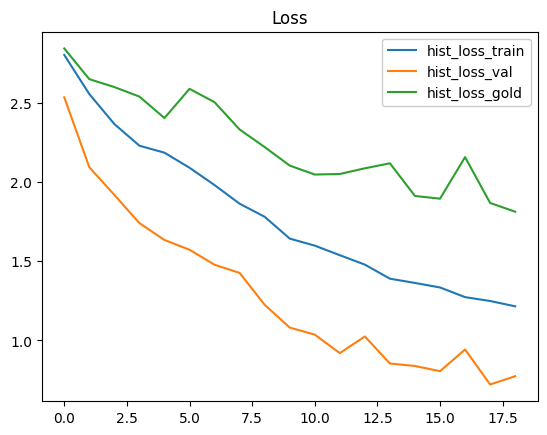

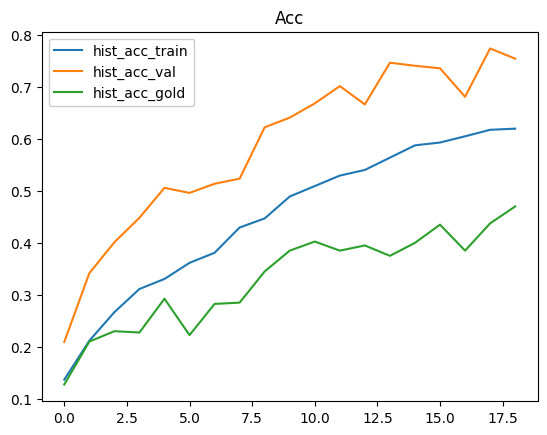

KeyboardInterrupt: 

In [16]:
worker(1,1)

## Продолжаем

In [11]:
batches=BATCHES = {'train':2,'val':10,'gold':10}
DATA_FOLDER = "/MAIN/files20"
# 1) Загружаем состояние
with open('rnn_conv_ds_08.12.54.pkl', 'rb') as f:
    state = cloudpickle.load(f)

# 2) Вытаскиваем всё
train_idxs = state['train_idxs']
val_idxs = state['val_idxs']
gold_idxs = state['gold_idxs']
SEQ_LEN  = state['seq_len']
IMG_SIZE = state['img_size']
data_transforms = {"train":state['train_data_transforms'],
    "val": state['val_data_transforms'],
    "gold": state['gold_data_transforms'],
      }
class_names     = state['class_names']

# 3) Реконструируем DataLoader’ы «на лету»
image_datasets= {
    'train': SequenceFolder(DATA_FOLDER, SEQ_LEN,
                          allowed_idxs=train_idxs,
                          transform=data_transforms['train']),
    'val': SequenceFolder(DATA_FOLDER, SEQ_LEN,
                          allowed_idxs=val_idxs,
                          transform=data_transforms['val']),
    'gold': SequenceFolder(DATA_FOLDER, SEQ_LEN,
                          allowed_idxs=gold_idxs,
                          transform=data_transforms['gold'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size= batches['train'], shuffle=True,  num_workers=10),
    'val': DataLoader(image_datasets['val'],   batch_size= batches['val'] , shuffle=True, num_workers=10),
    'gold': DataLoader(image_datasets['gold'],   batch_size= batches['gold'] , shuffle=True, num_workers=10),
    }
dataset_sizes = { 'train': len(image_datasets['train']), 'val': len(image_datasets["val"]) , 'gold': len(image_datasets["gold"])}

FileNotFoundError: Found no valid file for the classes n01675722, n01755581, n01798484, n02087046, n02091467, n02106030, n02110185, n02113624, n02125311, n02361337, n02442845, n02493509, n02793495, n02802426, n02843684, n02977058, n03223299, n03457902, n03825788, n04147183. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

In [23]:
# model = torch.load("rnn_conv_16.14.50.pth")
model = torch.load("rnn_conv_10.32.43.pth")

/tmp/ipykernel_4078/1139656377.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("rnn_conv_10.32.43.pth")


In [24]:
trainable_params = sum(
    p.numel()        # возвращает количество элементов в тензоре
    for p in model.parameters()
    if p.requires_grad  # только параметры, которые участвуют в градиенте
)

print(f"Количество обучаемых параметров: {trainable_params}")

Количество обучаемых параметров: 4711444


In [25]:
criterion = nn.CrossEntropyLoss()
param_groups = [
    { 'params': [p for n,p in model.named_parameters() if 'bias' not in n],
      'weight_decay': 1e-2 },
    { 'params': [p for n,p in model.named_parameters() if 'bias'   in n],
      'weight_decay': 0    },
]
optimizer = torch.optim.AdamW(param_groups, lr=5e-4)

scheduler = SmoothedReduceLROnPlateau(
            optimizer=optimizer,
            factor=0.7,
            patience=7,
            start_epoch=1,
            window_size=10,
            min_lr=0.5e-5,
            verbose=True,
            mode='min'
        )  

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

epoch:29 time:881.6 acc:0.9393


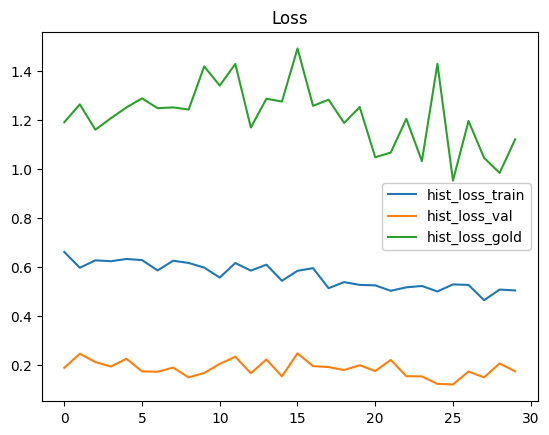

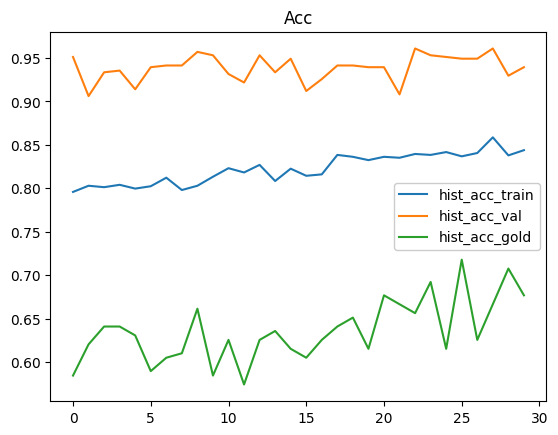

In [ ]:
model,best_acc,time_elapsed,fig,dict_hist = train_model(model, criterion, optimizer, scheduler, num_epochs=100, device = device)

In [185]:
# clear_ram()

#206M 344М модель

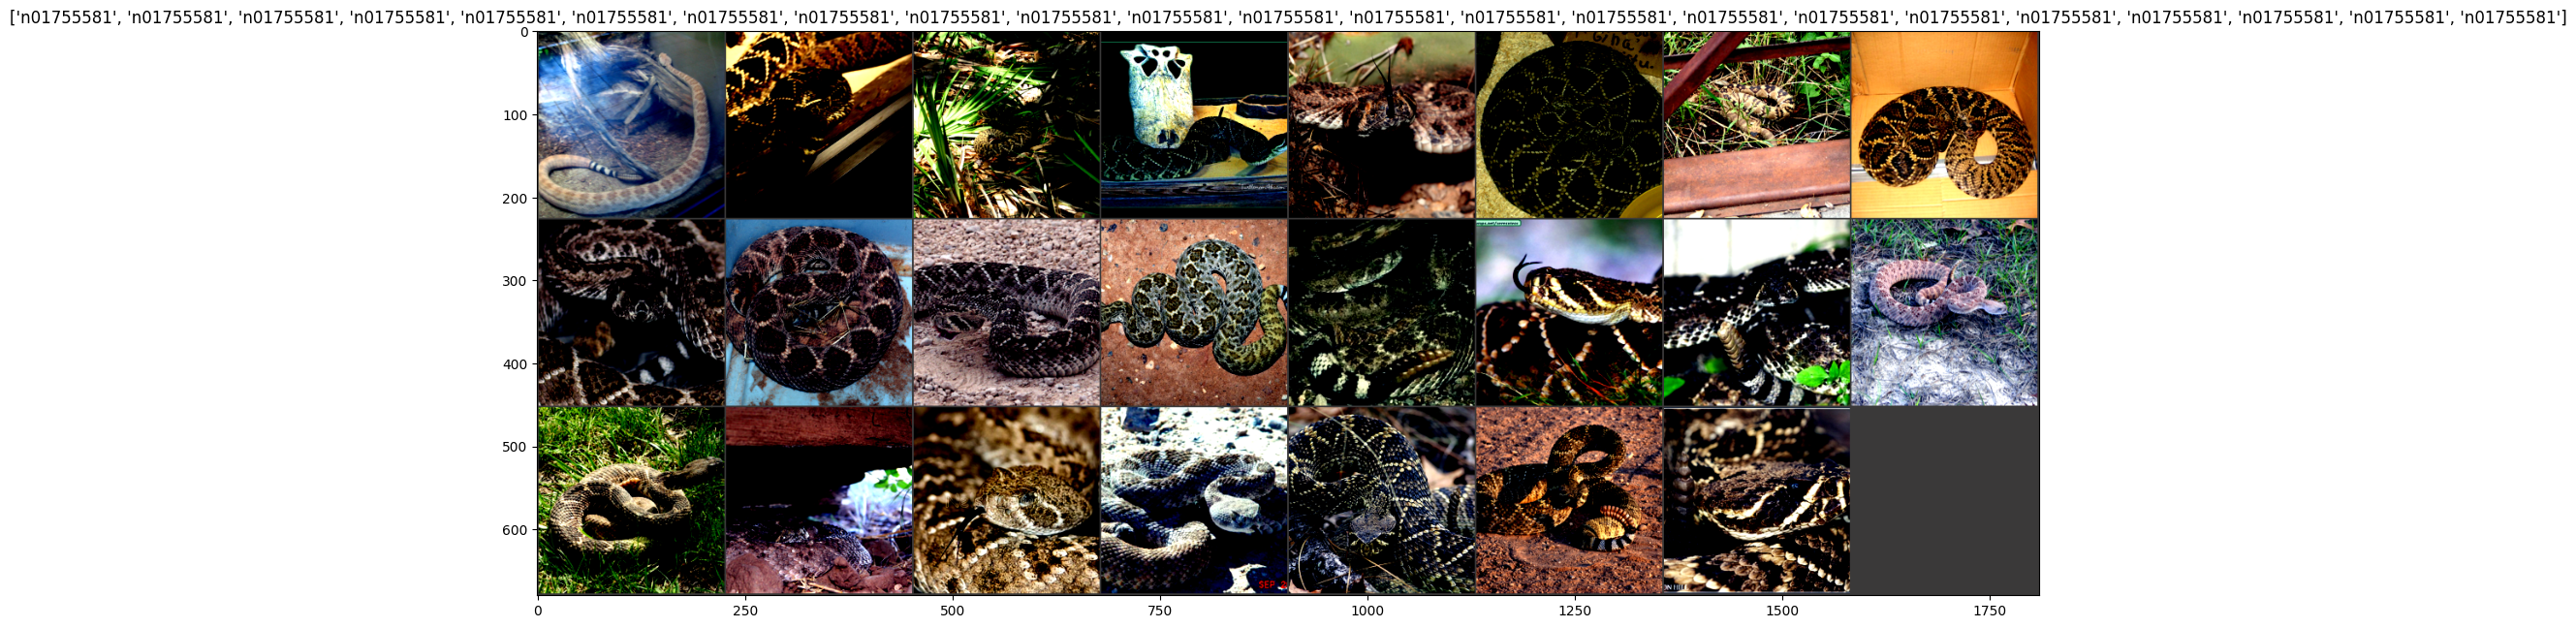

In [64]:
import torchvision
def imshow(inp, title=None):
    """Imshow for Tensor."""
    mean=  torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std= torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    inp = inp * mean
    inp = inp + std
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    # plt.imsave("dataset_samples.png",inp)
    plt.show()
    # with open("dataset_samples.txt", "w") as output:
    #     output.write(str(title))
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0])
plt.figure(figsize=(20,20))
cl = [int(classes[0])] * inputs[0].shape[0]
imshow(out, title=[class_names[c] for c in cl])

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Стандартный acc и матрицу ошибок

In [65]:
SEQ_LEN = 23
criterion = nn.CrossEntropyLoss()
true_classes = []
pred_classes = []
running_corrects = running_loss = cnt = 0
for inputs, labels in dataloaders["val"]:
    true_classes += [class_names[l] for l in labels]
    cnt += len(labels)
    with torch.inference_mode():
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        pred_classes += [class_names[c] for c in preds]
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    gc.collect()
    torch.cuda.empty_cache()
epoch_loss = running_loss / dataset_sizes["val"]
epoch_acc = running_corrects.double() / dataset_sizes["val"]

In [66]:
epoch_acc

tensor(1., device='cuda:0', dtype=torch.float64)

In [68]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_classes, pred_classes, labels=class_names)
has_errors = (
    (cm.sum(axis=1) - np.diag(cm) > 0)  # ошибки по истинным меткам
    | 
    (cm.sum(axis=0) - np.diag(cm) > 0)  # ошибки по предсказанным меткам
)

# 3) Отфильтровываем и строки, и столбцы
labels_err = np.array(class_names)[has_errors]
cm_err = cm[np.ix_(has_errors, has_errors)]

plt.figure(figsize=(12, 10), dpi=200) 
sns.heatmap(
    cm_err,
    annot=True,
    fmt='d',
    xticklabels=labels_err,
    yticklabels=labels_err,
    cmap='Blues',
    # cbar_kws={'shrink': 0.8}   # опционально — чуть уменьшить панель цвета
)

# Развернуть подписи по оси X
plt.xticks(rotation=90, fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.tight_layout()
plt.show()

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 2400x2000 with 0 Axes>

## Одиночные

In [100]:
trans = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=.05, hue=0.03),    # hue=.05
        transforms.RandomRotation((-20,20),interpolation=torchvision.transforms.InterpolationMode.BILINEAR), # аугментация, попробовать в конце!
    ])

In [90]:
trans = transforms.Compose([        
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.RandomAffine(
                degrees=0,
                translate=(0.1,0.1),
                scale=(0.8,1.2),
                shear=10
            ),
            # Color
            transforms.ColorJitter(0.4,0.4,0.4,0.1),
            transforms.RandomGrayscale(p=0.2),
            # Blur & distortion
            transforms.RandomApply(
                [transforms.GaussianBlur(kernel_size=(5,9), sigma=(0.1,2.0))], 
                p=0.5
            ),
            transforms.RandomPerspective(distortion_scale=0.5, p=0.2),
            # Cutout-style
            transforms.RandomErasing(
                p=0.25,
                scale=(0.02,0.33),
                ratio=(0.3,3.3),
                value='random'
            ),
            # Auto-augment (опционально)
            # transforms.RandAugment(num_ops=2, magnitude=9),
        ])

In [106]:
def prep_batch(inputs):
    for b in range(len(inputs)):
        n = inputs[b].shape[0]
        t = random.randint(0, n-1)
        for i in range(n):
            if i==t: continue
            inputs[b][i] = trans(torch.clone(inputs[b][t]))
            # inputs[b][i] = torch.clone(inputs[b][t])
        

In [139]:
SEQ_LEN = 23
criterion = nn.CrossEntropyLoss()
running_corrects = running_loss = cnt = 0
for inputs, labels in dataloaders["gold"]:
    cnt += len(labels)
    with torch.inference_mode():
        inputs = inputs.to(device)
        prep_batch(inputs)
        # inputs[:, 1:, ...] = 0
        # inputs = inputs[:, 0:1, :, :, :]
        # inputs = torch.cat([inputs, inputs], dim=1)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    gc.collect()
    torch.cuda.empty_cache()
epoch_loss = running_loss / dataset_sizes["gold"]
epoch_acc = running_corrects.double() / dataset_sizes["gold"]

In [140]:
epoch_acc

tensor(0.5513, device='cuda:0', dtype=torch.float64)

## Тест с дополненными 0-ми